# Inspect UMAP of COI

The setup of this notebooks is to transform the data with UMAP and color the manifold according to labels and fluorescence intensity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
import umap
import dask.dataframe as dd
from ehv import core, load as e_load
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib

In [60]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=6, threads_per_worker=1)
client = Client(cluster)

In [61]:
data_dd = e_load.load_raw_ideas_dir_dask(
    Path("/data/weizmann/EhV/high_time_res"), Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"),
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"), 
    pandas.read_csv("data/selected_samples.csv"))
data_dd = data_dd.map_partitions(e_load.remove_unwanted_features)
data_dd = data_dd.map_partitions(e_load.tag_columns)
data_dd = data_dd.map_partitions(e_load.add_merged_col, cols=["meta_group", "meta_timepoint", "meta_replicate", "meta_Object Number"])

In [62]:
# filter out non-COI cells
data_dd = data_dd.map_partitions(lambda p: p[p["meta_label_COI"]==True])

In [63]:
with open("data/selected_features.txt") as fh:
    features = fh.read().split(",")
features.extend(data_dd.partitions[0].compute().filter(regex="meta").columns.values.tolist())

In [64]:
data_dd = data_dd.map_partitions(lambda p: p[features])

In [65]:
data_dd = data_dd.repartition(npartitions=10)

In [66]:
data_dd = data_dd.persist()

# High samples (COI only)

In [52]:
def do_umap(data, **umap_args):
    projector = umap.UMAP(**umap_args)
    projection = projector.fit_transform(data.filter(regex="feat_.*"))
    projection = pandas.DataFrame(projection, columns=["dim_%d" % i for i in range(1, projector.get_params()["n_components"]+1)])
    return pandas.concat([data[["meta_id"]].reset_index(drop=True), projection], axis=1)

## Compute 2D projection

In [53]:
meta_df = data_dd[["meta_id"]].head(0)
meta_df["dim_1"] = 0.0
meta_df["dim_2"] = 0.0
meta_df.head()

,meta_id,dim_1,dim_2


In [20]:
%%time
projected = data_dd[data_dd["meta_group"] == "High"].groupby("meta_timepoint").apply(do_umap, n_components=2, meta=meta_df).compute()
projected = projected.reset_index(drop=True)

CPU times: user 1min 33s, sys: 6.07 s, total: 1min 39s
Wall time: 3min 9s


In [44]:
dump(projected, "data/umap/HTR_High_COI_pertp_after_selection.dat")

['data/umap/HTR_High_COI_pertp_after_selection.dat']

In [54]:
%%time
projected = data_dd[data_dd["meta_group"] == "Low"].groupby("meta_timepoint").apply(do_umap, n_components=2, meta=meta_df).compute()
projected = projected.reset_index(drop=True)

CPU times: user 2min 19s, sys: 13 s, total: 2min 32s
Wall time: 3min 32s


In [55]:
dump(projected, "data/umap/HTR_Low_COI_pertp_after_selection.dat")

['data/umap/HTR_Low_COI_pertp_after_selection.dat']

In [67]:
data = data_dd.compute()

In [68]:
client.cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


## Inspect 2D projection (for low viral load)

In [41]:
projected = load("data/umap/HTR_Low_COI_pertp_after_selection.dat")

In [69]:
projected.head()

,meta_id,dim_1,dim_2
0,Low1R20,-0.093031,6.678599
1,Low1R24,-0.916765,9.254587
2,Low1R27,-2.198189,10.273118
3,Low1R29,-1.619407,10.513697
4,Low1R216,-2.279379,8.771994


In [70]:
df = data[data["meta_group"] == "Low"].set_index("meta_id").join(projected.set_index("meta_id"))

In [71]:
selector = (df["meta_timepoint"]==7) & (df["meta_replicate"]=="R1")

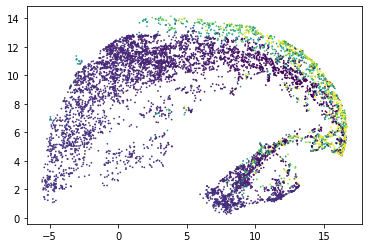

In [72]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Intensity_MC_Ch04"].quantile(0.05), vmax=df.loc[selector, "feat_Intensity_MC_Ch04"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Intensity_MC_Ch04"], s=0.5, cmap="viridis", norm=norm)

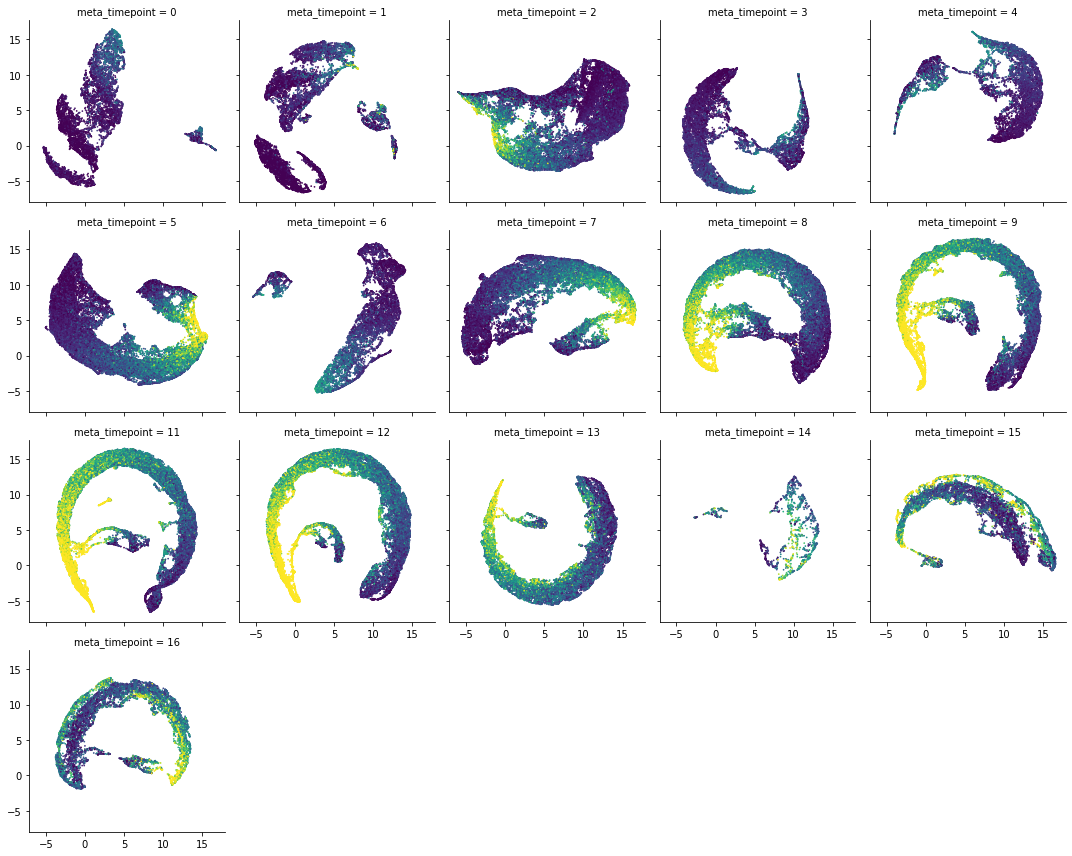

In [74]:
def scatter(x, y, c, **kwargs):
    del kwargs["color"]
    plt.scatter(x, y, c=c, **kwargs)

feat = "feat_Area_M07"
norm = matplotlib.colors.Normalize(vmin=df.loc[df["meta_group"] == "Low", feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
grid = seaborn.FacetGrid(col="meta_timepoint", data=df, col_wrap=5)
grid = grid.map_dataframe(scatter, 
                x="dim_1", y="dim_2", c=feat, s=0.5, cmap="viridis", norm=norm)
# grid.add_legend()

# for handle in grid._legend.legendHandles:
#     handle.set_sizes([30])
#     handle.set_alpha(1.0)
    
# plt.savefig("figs/umap/HTR_High_ALL_pertp.png")

## Inspect 2D projection (for high viral load)

In [41]:
projected = load("data/umap/HTR_High_COI_pertp_after_selection.dat")

In [23]:
projected.head()

,meta_id,dim_1,dim_2
0,High1R21,10.957961,12.168464
1,High1R27,6.011353,2.429932
2,High1R211,11.919767,11.583118
3,High1R212,14.035686,4.637509
4,High1R215,12.348964,4.779222


In [24]:
df = data[data["meta_group"] == "High"].set_index("meta_id").join(projected.set_index("meta_id"))

In [26]:
selector = (df["meta_timepoint"]==7) & (df["meta_replicate"]=="R1")

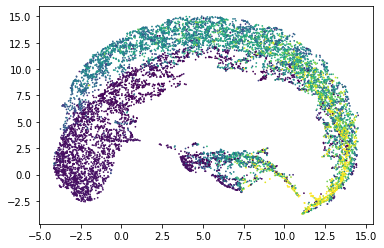

In [27]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Intensity_MC_Ch04"].quantile(0.05), vmax=df.loc[selector, "feat_Intensity_MC_Ch04"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Intensity_MC_Ch04"], s=0.5, cmap="viridis", norm=norm)

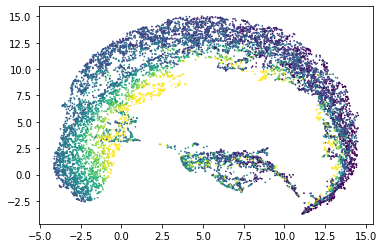

In [28]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Intensity_MC_Ch11"].quantile(0.05), vmax=df.loc[selector, "feat_Intensity_MC_Ch11"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Intensity_MC_Ch11"], s=0.5, cmap="viridis", norm=norm)

In [29]:
correlation = df.loc[selector].corr()

In [30]:
correlation["dim_1"].abs().sort_values(ascending=False)[:20]

dim_1                                      1.000000
feat_Intensity_MC_Ch7                      0.844948
feat_Intensity_MC_BF2                      0.811694
feat_Intensity_MC_Ch03                     0.786966
feat_Area_M03                              0.737703
feat_Mean Pixel_M09_BF2                    0.684157
feat_Bright Detail Intensity R3_MC_Ch03    0.676615
feat_Width_M03                             0.669502
feat_Bright Detail Intensity R3_MC_Ch7     0.667012
feat_Area_M07                              0.655757
feat_Intensity_MC_Ch04                     0.628908
feat_Length_M03                            0.626408
feat_Height_M03                            0.625846
feat_Length_M04                            0.621126
feat_Height_M04                            0.620931
feat_Width_M04                             0.609384
feat_Width_M07                             0.605571
feat_Bright Detail Intensity R3_MC_Ch04    0.604543
feat_Median Pixel_M04_Ch04                 0.594399
feat_Modulat

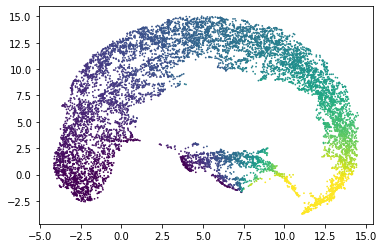

In [31]:
feat = "feat_Intensity_MC_Ch7"
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, feat], s=0.5, cmap="viridis", norm=norm)

In [32]:
correlation["dim_2"].abs().sort_values(ascending=False)[:20]

dim_2                                     1.000000
feat_Bright Detail Intensity R3_MC_BF2    0.446727
feat_Bright Detail Intensity R3_MC_SSC    0.421393
feat_Intensity_MC_SSC                     0.415502
feat_Gradient RMS_M03_Ch03                0.415016
feat_Mean Pixel_M06_SSC                   0.411324
feat_Median Pixel_M06_SSC                 0.409924
feat_Max Pixel_MC_SSC                     0.402517
feat_Area_M01                             0.393806
feat_Bright Detail Intensity R3_MC_BF     0.386681
feat_Area_M09                             0.381813
feat_Modulation_M04_Ch04                  0.380943
feat_Contrast_M04_Ch04                    0.364812
feat_Area_MC                              0.358695
feat_Length_M01                           0.354105
feat_Height_M01                           0.353476
feat_Modulation_M09_BF2                   0.352796
meta_label_MCP_NEG_PSBA_POS               0.352488
feat_Length_M09                           0.350090
feat_Height_M09                

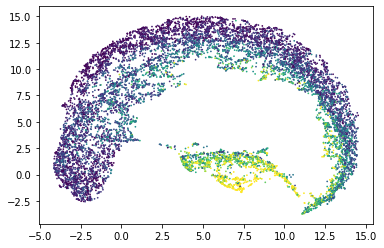

In [33]:
feat = "feat_Bright Detail Intensity R3_MC_BF2"
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, feat], s=0.5, cmap="viridis", norm=norm)

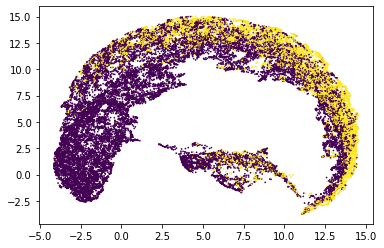

In [36]:
tmp = df[df["meta_timepoint"]==7]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]==7]["meta_label_MCP_POS_PSBA_NEG"].astype(float), s=0.5)

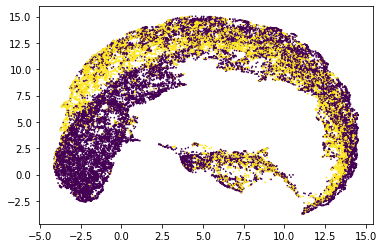

In [37]:
tmp = df[df["meta_timepoint"]==7]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]==7]["meta_label_MCP_POS_PSBA_POS"].astype(float), s=0.5)

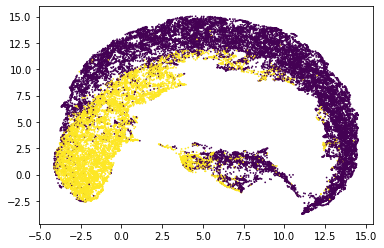

In [38]:
tmp = df[df["meta_timepoint"]==7]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]==7]["meta_label_MCP_NEG_PSBA_POS"].astype(float), s=0.5)

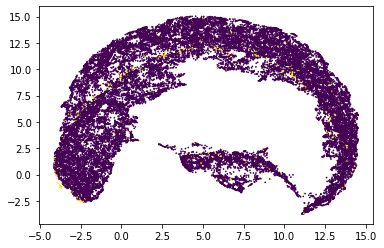

In [39]:
tmp = df[df["meta_timepoint"]==7]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]==7]["meta_label_MCP_NEG_PSBA_NEG"].astype(float), s=0.5)

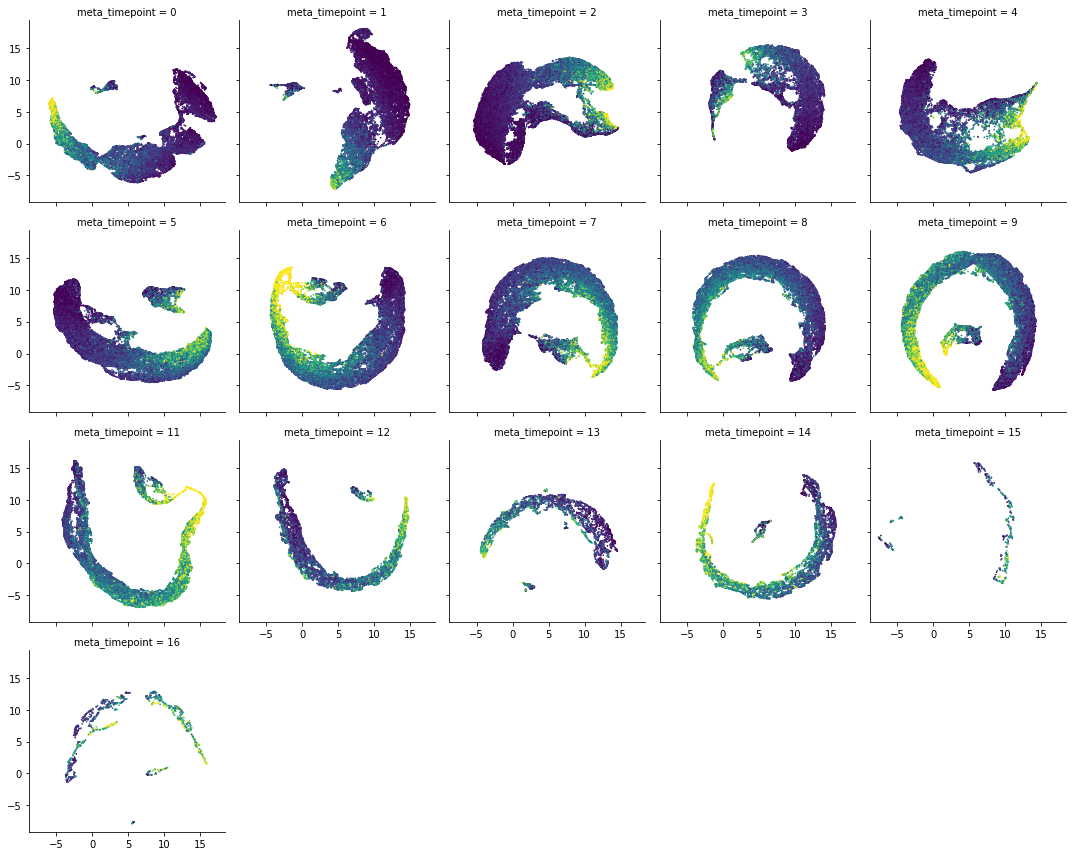

In [43]:
def scatter(x, y, c, **kwargs):
    del kwargs["color"]
    plt.scatter(x, y, c=c, **kwargs)

feat = "feat_Area_M07"
norm = matplotlib.colors.Normalize(vmin=df.loc[df["meta_group"] == "High", feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
grid = seaborn.FacetGrid(col="meta_timepoint", data=df, col_wrap=5)
grid = grid.map_dataframe(scatter, 
                x="dim_1", y="dim_2", c=feat, s=0.5, cmap="viridis", norm=norm)
# grid.add_legend()

# for handle in grid._legend.legendHandles:
#     handle.set_sizes([30])
#     handle.set_alpha(1.0)
    
# plt.savefig("figs/umap/HTR_High_ALL_pertp.png")